<a href="https://colab.research.google.com/github/alice202122/AI_PROJECT/blob/main/AI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CONNECTING TO DRIVE

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
%cd /gdrive/MyDrive/AI_Assignment/training_set

In [ ]:
!unzip training_set.zip

# IMPORTING LIBRARIES

In [ ]:
from scipy.io import loadmat

import numpy as np, os
from numpy import array, matrix, multiply, arange, absolute

from scipy import signal
from scipy import stats
from scipy.signal import lfilter, medfilt, resample, kaiserord, firwin, freqz, correlate

import pandas as pd

import ntpath

import matplotlib.pyplot as plt
from matplotlib import pylab as plt
 
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show, legend, axis

import copy

!pip install pyhrv
import pyhrv
import pyhrv.time_domain as td

!pip install biosppy
import biosppy
from biosppy.signals import ecg, tools

import math
from math import pi

#DATA LOADING

In [6]:
input_directory = '/gdrive/MyDrive/AI_Assignment/training_set'

We want to adjust the dataset in a matrix to better organize the available data. The matrix structure is the following:

    | ECG (I & II lead) | R peaks location (samples) | Beats annotation ('N', 'S', 'V') |


In [7]:
def storage(empty_list, input_directory, last_character, name):

  for file in sorted(os.listdir(input_directory)):       # search amongst files in input directory
    filename = ntpath.basename(file)                     # get file name
    filename = os.path.splitext(filename)[0]             # remove file extension
    if filename.endswith(last_character):                # check filename last character
      mat_file = filename + '.mat'                       # rejoin extension to filename
      x = loadmat(mat_file)                              # load file
      values = np.asarray(x[name])                       # load values
      empty_list.append(values)                          # store values in a list

  num_files = len(empty_list)                            # checking all files have been stored

  return empty_list, num_files

###ECGs

In [8]:
ECGs = []         # list initialization
ECGs, num_files = storage(ECGs, input_directory, ('8','0'), 'ecg')
num_files

105

###R PEAKS LOCATION 

In [9]:
Rpks = []          # list initialization
Rpks, num_files = storage(Rpks, input_directory, 'k', 'rpeaks')
num_files

105

###BEATS ANNOTATIONS

In [10]:
beats_anns = []    # list initialization
beats_anns, num_files = storage(beats_anns, input_directory, 'n', 'labels')
num_files

105

###FINAL MATRIX

In [11]:
data = []                                                                         # list initialization
row = []                                                                          # list initialization
for patient in range(num_files):                                                  # scrolls patient by patient
  row = [ ECGs[patient], Rpks[patient], beats_anns[patient] ]  
  data.append(row)                                                                # store row in a list
#pd.DataFrame(data, columns=['ECG (I & II lead)', 'R peaks location (samples)', 'Beats annotation'])

#DATA INSPECTION

###SIGNALS LENGTH DISTRIBUTION

In [12]:
def signals_lenght_distr(input_directory, last_character, fs):       

  ECGs_fs = []
  ECGs, num_files = storage(ECGs_fs, input_directory, last_character, 'ecg') 

  ECG = 0                                                    
  ECGsfs_lengths = []                                   # list initialization
  for patient in range(len(ECGs_fs)):                   # scrolls patient by patient
    ECGsfs_lengths.append(len(data[patient][ECG])/fs)   # store signals length in a list

  ECGsfs_lengths = pd.Series(ECGsfs_lengths)
  ax = ECGsfs_lengths.plot.hist(bins=12, alpha=0.5)
  ax.set_title("Signals length distribution (fs = " + str(fs) + " Hz)")

  return ECGs_fs, num_files

####128 Hz signals

65

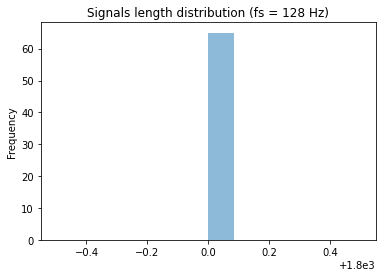

In [13]:
ECGs_128, num_files = signals_lenght_distr(input_directory, '8', 128)
num_files   # checking all files have been stored

####250 Hz signals

40

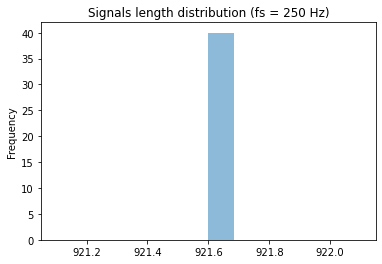

In [14]:
ECGs_250, num_files = signals_lenght_distr(input_directory, '0', 250)
num_files   # checking all files have been stored

###OTHERS

#PRE-PROCESSING

###UPSAMPLING

Upsampling is the process of inserting zero-valued samples between the original samples of a signal to increase the sampling rate. We want, indeed, to bring all the signals at the same sampling frequency of 250 Hz. Downsampling to the 128 Hz is not recommendable otherwise we would lose informations.

In [15]:
def upsampling(ECG_old, fs_old, fs_up):

  deltafs_old = 1/fs_old                                                          # old sampling interval (s)
  duration_old = int(deltafs_old*len(ECG_old))                                    # signal duration (s)
  samples_old = duration_old*fs_old                                               # number of samples with old sampling frequency
  timevec_old = np.linspace(0, duration_old, samples_old, False)                  # old time vector

  deltafs_up = 1/fs_up                                                            # new sampling interval (s)
  samples_up = duration_old*fs_up                                                 # number of samples expected with new sampling frequency
  timevec_up = np.linspace(0, duration_old, samples_up, False)                    # new time vector

  ECG_up = signal.resample(ECG_old, samples_up)                                   # ECG upsampled

  return timevec_old, timevec_up, ECG_up

####Example for one signal

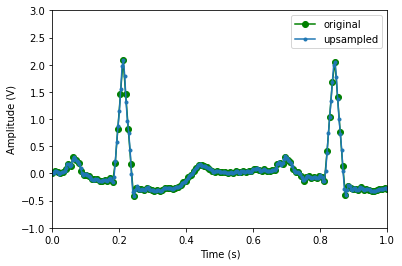

In [16]:
patient = 0
ECG = 0
Ilead = 0
ECG_128 = data[patient][ECG][:,Ilead]        # ECG I lead from patient S001_128

time_128, time_250, ECG128_up = upsampling(ECG_128, 128, 250)

plt.plot(time_128, ECG_128, 'go-', time_250, ECG128_up, '.-')
plt.axis([0, 1, -1, 3])                                         
plt.legend(['original', 'upsampled'], loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

####For all 128 Hz signals

In [17]:
ECGs128_up = []                                      # list initialization
ECG = 0
for patient in range(len(ECGs_128)):                 # scrolls patient by patient
  ECG_128 = data[patient][ECG]                       # both ECG leads
  ECG128_up = upsampling(ECG_128, 128, 250)[2]       # ECG upsampled
  ECGs128_up.append(ECG128_up)                       # store ECGs upsampled in a list

In [18]:
ECGs_up = ECGs128_up                      # new array of upsampled ECGs
for patient in range(len(ECGs_250)):      # scroll patient by patient
  ECGs_up.append(ECGs_250[patient])       # append the ECGs at 250 Hz
num_files = len(ECGs_up)                             
num_files                                 # checking all files have been stored        

105

In [19]:
data_up = []                                                                     # list initialization
row = []                                                                         # list initialization
for patient in range(num_files):                                                 # scrolls patient by patient
  row = [ ECGs_up[patient], Rpks[patient], beats_anns[patient] ]                 # store ECG upsampled, R peaks location, beats annotation for each patient in a row
  data_up.append(row)                                                            # store row in a list
#pd.DataFrame(data_up, columns=['ECG (I & II lead)', 'R peaks location (samples)', 'Beats annotation'])

In [20]:
fs = 250              # sampling frequency (Hz)
delta_fs = 1/fs       # sampling interval (s)

###BASELINE DETECTION

We want to detect the baseline and remove it from the overall signals because not necessary to the features of interest when computing the power spectrum. Indeed, the baseline wander mainly corresponds to the movement and respiration of the patient.

####Example for one signal

Text(0, 0.5, 'Amplitude (V)')

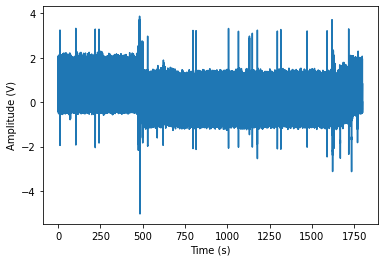

In [21]:
patient = 0
ECG = 0
Ilead = 0
ECG = data_up[patient][ECG][:,Ilead]       # ECG I lead from patient S001_128 (S001_250)

duration = int(delta_fs*len(ECG))                                 # signal duration (s)
samples = duration*fs                                             # number of samples
time_vec = np.linspace(0, duration, samples, endpoint=False)      # time vector

plot(time_vec, ECG)
xlabel('Time (s)')
ylabel('Amplitude (V)')

In [22]:
def power_spectrum(data, sampling_rate):
  fourier_transform = np.fft.rfft(data)                                 # FFT computation
  abs_fourier_transform = np.abs(fourier_transform)                     # FFT absolute value
  power_spectrum = np.square(abs_fourier_transform)                     # power spectrum
  frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))      # vector of frequencies

  return frequency, power_spectrum

Text(0, 0.5, 'Power Spectrum (dB/Hz)')

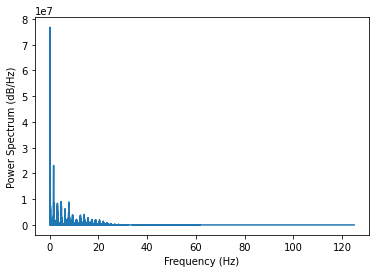

In [23]:
ECG_f, ECG_ps = power_spectrum(ECG, fs)
plt.plot(ECG_f, ECG_ps)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum (dB/Hz)')

Plotting the signal in the frequency domain we are able to detect the baseline contribution as the highest peak.

######Median Filter (200 ms)

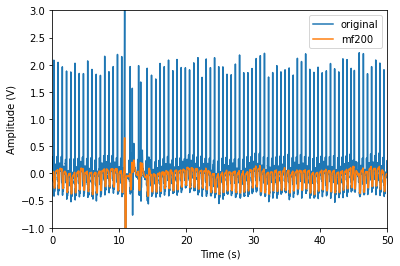

In [25]:
kernel_t = 0.2
kernel_smp = kernel_t*fs
ECG_mf200 = signal.medfilt(ECG, int(kernel_smp)+1)      # +1 the one being filtered
plt.plot(time_vec, ECG, time_vec, ECG_mf200)
plt.axis([0, 50, -1, 3])
plt.legend(['original', 'mf200'], loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

######Median Filter (600 ms)

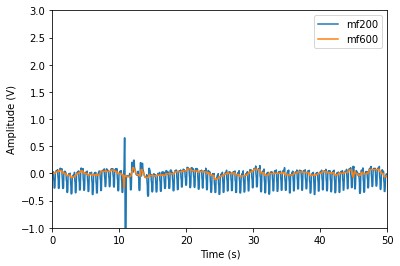

In [26]:
kernel_t = 0.6
kernel_smp = kernel_t*fs
ECG_mf600 = signal.medfilt(ECG_mf200, int(kernel_smp)+1)      # +1 the one being filtered
plt.plot(time_vec, ECG_mf200, time_vec, ECG_mf600)
plt.axis([0, 50, -1, 3])
plt.legend(['mf200', 'mf600'], loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

######Baseline Removal

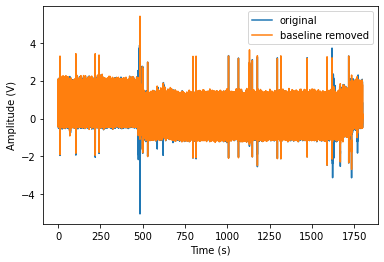

In [27]:
ECG_blr = ECG-ECG_mf600
plt.plot(time_vec, ECG, time_vec, ECG_blr)
plt.legend(['original', 'baseline removed'], loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

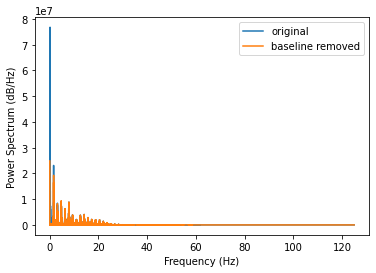

In [28]:
ECGblr_f, ECGblr_ps = power_spectrum(ECG_blr, fs)
plt.plot(ECG_f, ECG_ps, ECGblr_f, ECGblr_ps)
plt.legend(['original', 'baseline removed'], loc='best')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum (dB/Hz)')
plt.show()

As we can see the baseline component has been removed.

####For all signals

In [30]:
ECGsup_blr = []
ECG = 0
Ilead = 0
IIlead = 1
for patient in range(num_files):                      # scrolls patient by patient
  ECGI_up = data_up[patient][ECG][:,Ilead]
  kernel_t = 0.2
  kernel_smp = kernel_t*fs          
  ECGIup_mf200 = signal.medfilt(ECGI_up, int(kernel_smp)+1)         # +1 the one being filtered
  kernel_t = 0.6
  kernel_smp = kernel_t*fs 
  ECGIup_mf600 = signal.medfilt(ECGIup_mf200, int(kernel_smp)+1)    # +1 the one being filtered
  ECGIup_blr = ECGI_up-ECGIup_mf600                            # baseline removal
  ECGII_up = data_up[patient][ECG][:,IIlead]  
  kernel_t = 0.2
  kernel_smp = kernel_t*fs          
  ECGIIup_mf200 = signal.medfilt(ECGII_up, int(kernel_smp)+1)          # +1 the one being filtered
  kernel_t = 0.6
  kernel_smp = kernel_t*fs
  ECGIIup_mf600 = signal.medfilt(ECGIIup_mf200, int(kernel_smp)+1)     # +1 the one being filtered
  ECGIIup_blr = ECGII_up-ECGIIup_mf600                            # baseline removal
  ECGup_blr = [ECGIup_blr, ECGIIup_blr]
  ECGsup_blr.append(ECGup_blr)

In [31]:
dataup_blr = []                                                                  # list initialization
row = []                                                                         # list initialization
for patient in range(num_files):                                                 # scrolls patient by patient
  row = [ ECGsup_blr[patient], Rpks[patient], beats_anns[patient] ]              # store ECG baseline removed, R peaks location, beats annotation for each patient in a row
  dataup_blr.append(row)                                                         # store row in a list
#pd.DataFrame(dataup_blr, columns=['ECG (I & II lead)', 'R peaks location (samples)', 'Beats annotation'])

###FILTERING

####Example for one signal

Text(0, 0.5, 'Amplitude (V)')

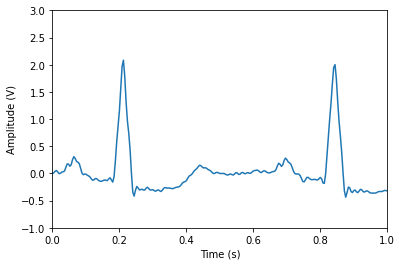

In [32]:
patient = 0
ECG = 0
Ilead = 0
ECG = dataup_blr[patient][ECG][Ilead]       # ECG I lead from patient S001_128 (S001_250)

duration = int(delta_fs*len(ECG))                                 # signal duration (s)
samples = duration*fs                                             # number of samples
time_vec = np.linspace(0, duration, samples, endpoint=False)      # time vector

plot(time_vec, ECG)
plt.axis([0, 1, -1, 3])
xlabel('Time (s)')
ylabel('Amplitude (V)')

From this plot it can be noticed that the ECG signal needs to be smoothed out. For this reason, we apply a low pass filter to get rid of the high frequencies responsible of those ripples.

In [33]:
def FIRlowpass(sample_rate, signal, time_axis, cutoff_hz, start, end, figs):

  nyq_rate = sample_rate / 2.0
  width = 5.0/nyq_rate # the desired width of the transition from pass to stop,
                       # relative to the Nyquist rate.  We'll design the filter
                       # with a 5 Hz transition width.
  ripple_db = 60.0     # the desired attenuation in the stop band, in dB
  N, beta = kaiserord(ripple_db, width) # compute the order and Kaiser parameter for the FIR filter.
  taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
  filtered = lfilter(taps, 1.0, signal)

  if figs == True:

    figure(1) # filter coefficients
    plot(taps, 'bo-', linewidth=2)
    title('Filter Coefficients (%d taps)' % N)
    grid(True)

    figure(2) # filter magnitude response
    clf()
    w, h = freqz(taps, worN=8000)
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlabel('Frequency (Hz)')
    ylabel('Gain')
    title('Frequency Response')
    ylim(-0.05, 1.05)
    grid(True)
    ax1 = axes([0.42, 0.6, .45, .25]) # upper inset plot
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlim(0,8.0)
    ylim(0.9985, 1.001)
    grid(True)
    ax2 = axes([0.42, 0.25, .45, .25]) # lower inset plot
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlim(60.0, 80.0)
    ylim(-0.05, 0.05)
    grid(True)

    delay = 0.5 * (N-1) / sample_rate # the phase delay of the filtered signal
    figure(3) # original vs filtered signal
    axis([start, end, -1, 3])
    plot(time_axis, signal)
    #plot(time_axis-delay, filtered_x, 'r-')
    plot(time_axis[N-1:]-delay, filtered[N-1:], 'r', linewidth=1) # plot just the "good" part of the filtered signal. The first N-1
                                                                    # samples are "corrupted" by the initial conditions.
    legend(['original', 'filtered'], loc='best')
    xlabel('Time (s)')
    ylabel('Amplitude (V)')
    grid(True)

    figure(4)
    signal_f, signal_ps = power_spectrum(signal, fs)
    filt_f, filt_ps = power_spectrum(filtered, fs)
    plot(signal_f, signal_ps, filt_f, filt_ps)
    legend(['original', 'filtered'], loc='best')
    xlabel('Frequency (Hz)')
    ylabel('Power Spectrum (dB/Hz)')

    show()
    
  elif figs == False:
    plt.close('all')

  return filtered

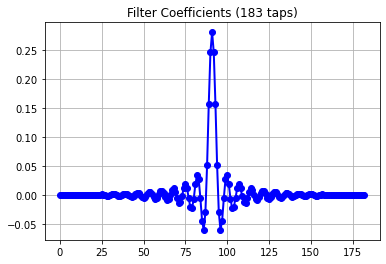

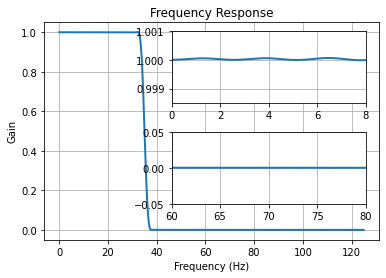

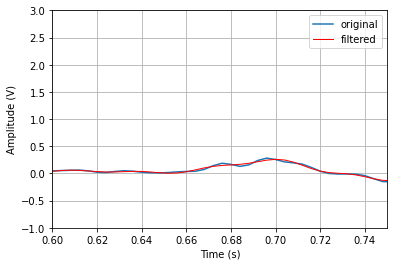

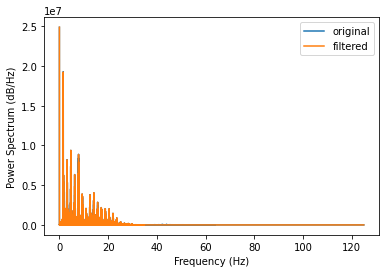

In [34]:
ECG_filt = FIRlowpass(fs, ECG, time_vec, 35, 0.60, 0.75, True)

####For all signals

In [35]:
ECGsupblr_filt = []
ECG = 0
Ilead = 0
IIlead = 1
for patient in range(num_files):                                                 # scrolls patient by patient
  ECGIup_blr = dataup_blr[patient][ECG][Ilead]            
  ECGIupblr_filt = FIRlowpass(fs, ECGIup_blr, time_vec, 35, [], [], False)         
  ECGIIup_blr = dataup_blr[patient][ECG][IIlead]            
  ECGIIupblr_filt = FIRlowpass(fs, ECGIIup_blr, time_vec, 35, [], [], False)
  ECGupblr_filt = [ECGIupblr_filt, ECGIIupblr_filt]
  ECGsupblr_filt.append(ECGupblr_filt)

In [36]:
dataupblr_filt = []                                                              # list initialization
row = []                                                                         # list initialization
for patient in range(num_files):                                                 # scrolls patient by patient
  row = [ ECGsupblr_filt[patient], Rpks[patient], beats_anns[patient] ]          # store ECG filtered, R peaks location, beats annotation for each patient in a row
  dataupblr_filt.append(row)                                                     # store row in a list
#pd.DataFrame(dataupblr_filt, columns=['ECG (I & II lead)', 'R peaks location (samples)', 'Beats annotation'])

#FEATURE EXTRACTION

###HRV FEATURES

For each individual beat, a set of features was computed taking into account the neighboring beats.
A window of three minutes centered around the current beat is considered for the extraction of the heart rate variability (HRV) features.

In [ ]:
wnw_3 = 180             # time window duration in s
wnw3_smp = wnw_3*fs     # number of samples in the window

temp = []
Rpks_wnw = []
row = []
lst = []
lst1 = []
lst2 = []
lst3 = []
lst4 = []
lst5 = []
lst6 = []
lst7 = []
lst8 = []
lst9 = []
lst10 = []


Rpks = 1

for patient in range(2):
  for idxi, i in enumerate(dataupblr_filt[patient][Rpks]):
    if (i-wnw3_smp)>0 and (i+wnw3_smp)<dataupblr_filt[patient][Rpks][-1]:
      temp = []
      RRs_mean = []
      RRs_std = []
      RMSSD = []
      dRRs_mean = []
      dRRs_std = []
      pNN10 = []
      pNN20 = []
      pNN30 = []
      pNN40 = []
      pNN50 = []
      for idkk, k in enumerate(dataupblr_filt[patient][Rpks]):
        if k>(i-wnw3_smp) and k<(i+wnw3_smp):           # window centered around the beat
          k_t = k/fs
          temp.append(k_t)
      temp = np.vstack(temp)
      lst = copy.deepcopy(temp)
      RRs = [j-i for i, j in zip(np.array(lst[:-1]), np.array(lst[1:]))]
      RRs = np.vstack(RRs)
      RRs_mean = np.mean(RRs)
      lst1 = copy.deepcopy(RRs_mean)
      RRs_std = np.std(RRs)
      lst2 = copy.deepcopy(RRs_std)
      #RMSSD = pyhrv.time_domain.rmssd(RRs, temp) 
      #lst3 = copy.deepcopy(RMSSD)
      dRRs = [j-i for i, j in zip(np.array(RRs[:-1]), np.array(RRs[1:]))]
      dRRs = np.vstack(dRRs)
      dRRs_mean = np.mean(dRRs)
      lst4 = copy.deepcopy(dRRs_mean)
      dRRs_std = np.std(dRRs)
      lst5 = copy.deepcopy(dRRs_std)
      pNN10 = sum([i>0.01 for i in dRRs])*100/len(dRRs)
      lst6 = copy.deepcopy(pNN10)
      pNN20 = sum([i>0.02 for i in dRRs])*100/len(dRRs)
      lst7 = copy.deepcopy(pNN20)
      pNN30 = sum([i>0.03 for i in dRRs])*100/len(dRRs)
      lst8 = copy.deepcopy(pNN30)
      pNN40 = sum([i>0.04 for i in dRRs])*100/len(dRRs)
      lst9 = copy.deepcopy(pNN40)
      pNN50 = sum([i>0.05 for i in dRRs])*100/len(dRRs)
      lst10 = copy.deepcopy(pNN50)
      row = [patient, i, lst, np.round(lst1,4), np.round(lst2,4), np.round(lst4,4), np.round(lst5,4), np.round(lst6,4), np.round(lst7,4), np.round(lst8,4), np.round(lst9,4), np.round(lst10,4)]
      Rpks_wnw.append(row)


In [ ]:
HRVwnw3_df = pd.DataFrame(Rpks_wnw, columns =['Patient', 'Beat location (sample)', 'Beat window (time)', 'RRs mean', 'RRs_std', 'dRRs_mean', 'dRRs_std', 'pNN10 (%)', 'pNN20 (%)', 'pNN30 (%)', 'pNN40 (%)', 'pNN50 (%)'])
HRVwnw3_df

###MORPHOLOGICAL FEATURES

Morphological information of the whole beat were extracted using a fixed window. However, it should be noted that as no ECG delineation is performed, the reported segments may not precisely account for these ECG regions (i.e., it is not an exact selection of the onset and offset of the ECG segment, but rather an approximate estimation). Nevertheless, the scope of this selection is to account for their intra-patient variability not to extract any precise parameter which could describe any of the ECG regions described above. Therefore, given that for the same patient the same ECG portion would be extracted for each of the mentioned segments, any variability produced by a premature atrial or ventricular beat, should be detected even if the ECG region is not accurately delineated.

####Example for one beat

#####Beat extraction

In [37]:
def extractor(wnwst_t, wnwend_t, lead):
  wnwst_smp = round(wnwst_t*fs)
  wnwend_smp = round(wnwend_t*fs)
  rows = []
  ECGs_wnw = []
  Rpks = 1
  for patient in range(num_files):
    rows = []
    for idx, i in enumerate(dataupblr_filt[patient][Rpks]): 
      if (i-wnwst_smp)>0 and (i+wnwend_smp)<dataupblr_filt[patient][Rpks][-1]:
        Rpk_t = i*delta_fs
        time = np.linspace((Rpk_t-wnwst_t), (Rpk_t+wnwend_t), wnwst_smp+wnwend_smp, endpoint=True)
        row = [ i, time, ECGsupblr_filt[patient][lead][int(i)-wnwst_smp:int(i)+wnwend_smp] ]
        rows.append(row)
    lst = copy.deepcopy(rows)
    perpatient = [ patient, lst ]
    ECGs_wnw.append(perpatient)

  return ECGs_wnw

In [38]:
wnwst_t = 0.3 
wnwend_t = 0.25
lead = 0    # I lead
ECGsIlead_wnw = extractor(wnwst_t, wnwend_t, lead)
lead = 1    # II lead
ECGsIIlead_wnw = extractor(wnwst_t, wnwend_t, lead)

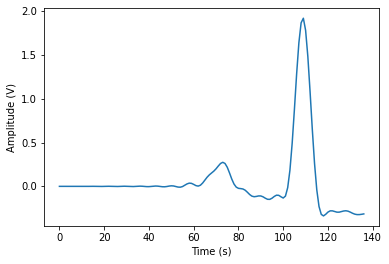

In [39]:
patient = 0
n_beat = 0
plot(ECGsIlead_wnw[patient][1][n_beat][2])
xlabel('Time (s)')
ylabel('Amplitude (V)')
show()
#pd.DataFrame(ECGs_wnw, columns=['Patient', 'R peak (sample) + Time (s) + ECG_wholebeat'])

#####Intra-patient template

An intra-patient template was created using the neighboring beats.

In [40]:
def template(data, n_prior, n_post):
  tplt = []
  for patient in range(num_files):
    tplt_temp = []
    for idx, i in enumerate(data[patient][1]):
      if (idx-n_prior)>0 and (idx+n_post)<len(data[patient][1]):
        row = [ data[patient][1][idx], data[patient][1][(idx-n_prior):(idx+n_post)] ]
        tplt_temp.append(row)
    lst = copy.deepcopy(tplt_temp)
    perpatient = [ patient, lst ]
    tplt.append(perpatient)

  return tplt

In [41]:
tpltIlead_25 = template(ECGsIlead_wnw, 25, 25)

######Alignment through cross-correlation

The surrounding beats' segments were aligned through cross-correlation.

In [99]:
patient = 0
middlebeatplusbeatsassoc = 1
n_middlebeatplusbeatsassoc = 0
middle_beat = 0
beats_assoc = 1
n_beatsassoc = 0
head = 0
t = 1
ecg = 2

26.0

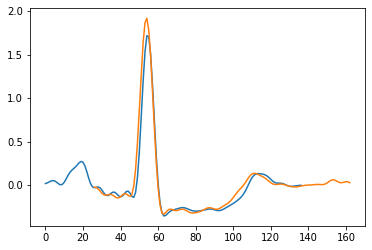

In [100]:
n_beat1 = tpltIlead_25[patient][middlebeatplusbeatsassoc][n_middlebeatplusbeatsassoc][middle_beat]
n_beat2 = tpltIlead_25[patient][middlebeatplusbeatsassoc][n_middlebeatplusbeatsassoc][beats_assoc][n_beatsassoc]
plt.plot(n_beat1[ecg])
for target in [ n_beat2 ]:
    time = np.arange(0, len(n_beat1[ecg]), 1)
    dx = np.mean(np.diff(time))
    shift = (np.argmax(signal.correlate(n_beat1[ecg], target[ecg])) - len(target[ecg])) * dx
    plt.plot(time+shift, target[ecg])
shift

In [171]:
temp = []
corr = []
beat_ecg = tpltIlead_25[patient][middlebeatplusbeatsassoc][n_middlebeatplusbeatsassoc][middle_beat][ecg]
lst = []  
for k in tpltIlead_25[patient][middlebeatplusbeatsassoc][n_middlebeatplusbeatsassoc][beats_assoc]:
  max = (np.argmax(signal.correlate(beat_ecg, k[ecg])) - len(k[ecg]))
  row = [ k[0:3], max ] 
  temp.append(row)
lst = copy.deepcopy(temp)
beat_max = [ tpltIlead_25[patient][middlebeatplusbeatsassoc][n_middlebeatplusbeatsassoc][middle_beat][head], lst]
corr.append(beat_max)
corr

[[array([2221], dtype=int32),
  [[[array([191], dtype=int32), array([[0.464     ],
            [0.46804412],
            [0.47208824],
            [0.47613235],
            [0.48017647],
            [0.48422059],
            [0.48826471],
            [0.49230882],
            [0.49635294],
            [0.50039706],
            [0.50444118],
            [0.50848529],
            [0.51252941],
            [0.51657353],
            [0.52061765],
            [0.52466176],
            [0.52870588],
            [0.53275   ],
            [0.53679412],
            [0.54083824],
            [0.54488235],
            [0.54892647],
            [0.55297059],
            [0.55701471],
            [0.56105882],
            [0.56510294],
            [0.56914706],
            [0.57319118],
            [0.57723529],
            [0.58127941],
            [0.58532353],
            [0.58936765],
            [0.59341176],
            [0.59745588],
            [0.6015    ],
            [0.60554412],
       

In [ ]:
corr[0][1]

######Outliers detection

Outlier segments, according to the maximum cross-correlation value obtained for alignment, were excluded from the mean.

In [190]:
df = pd.DataFrame(corr[0][1])
df['z_score'] = stats.zscore(df[1])
df

,0,1,z_score
0,"[[191], [[0.464], [0.46804411764705883], [0.47...",26,0.767798
1,"[[272], [[0.788], [0.7920441176470588], [0.796...",-51,-0.898506
2,"[[353], [[1.1119999999999999], [1.116044117647...",30,0.854359
3,"[[433], [[1.432], [1.4360441176470589], [1.440...",-48,-0.833585
4,"[[514], [[1.756], [1.760044117647059], [1.7640...",33,0.919280
5,"[[595], [[2.08], [2.0840441176470588], [2.0880...",-43,-0.725383
6,"[[676], [[2.4040000000000004], [2.408044117647...",38,1.027482
7,"[[758], [[2.732], [2.736044117647059], [2.7400...",-38,-0.617182
8,"[[839], [[3.056], [3.0600441176470587], [3.064...",43,1.135683
9,"[[919], [[3.3760000000000003], [3.380044117647...",-35,-0.552261


In [191]:
df_out = df.loc[df['z_score'].abs()<=0.5]
df_out

,0,1,z_score
11,"[[1083], [[4.032], [4.036044117647059], [4.040...",-28,-0.400779
13,"[[1245], [[4.680000000000001], [4.684044117647...",-25,-0.335858
21,"[[1896], [[7.284000000000001], [7.288044117647...",-8,0.032028
23,"[[2059], [[7.936000000000001], [7.940044117647...",-5,0.096949
25,"[[2221], [[8.584], [8.588044117647058], [8.592...",-1,0.183510
27,"[[2383], [[9.232], [9.236044117647058], [9.240...",2,0.248431
29,"[[2543], [[9.872], [9.876044117647059], [9.880...",3,0.270071
31,"[[2704], [[10.516], [10.520044117647059], [10....",6,0.334992
32,"[[2783], [[10.831999999999999], [10.8360441176...",-26,-0.357498
35,"[[3022], [[11.788], [11.792044117647059], [11....",9,0.399913


In [223]:
count = 0
sum = 0
for count in range(len(df_out)):
  sum = sum + df_out[0].iloc[count][2]

######Average

The surrounding beats' segments are eventually averaged for the computation of the intra-patient template.

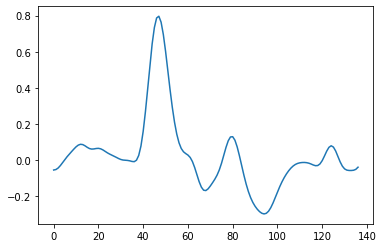

In [228]:
tpltIlead25_mean = np.vstack(sum)/len(df_out)
plot(tpltIlead25_mean)

#####Feature extraction

Once the intra-patient templates were computed, each beat of the subject was compared with the templates using cross-correlation. At the end of the process, for each beat, the following parameters were extracted and used as features:

* maximum cross-correlation value of each segment with respect to the different intra-patient templates created with the neighboring beats
* lag corresponding to the cross-correlation value described above
* median standard deviation of the beats used to create the intra-patient template

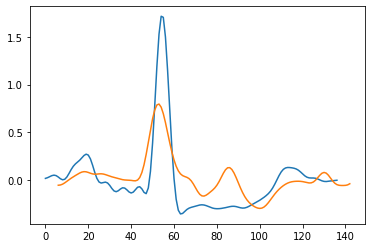

In [230]:
n_beat1 = tpltIlead_25[patient][middlebeatplusbeatsassoc][n_middlebeatplusbeatsassoc][middle_beat][ecg]
plt.plot(n_beat1)
time = np.arange(0, len(n_beat1), 1)
dx = np.mean(np.diff(time))
max = (np.argmax(signal.correlate(np.vstack(n_beat1), tpltIlead25_mean)) - len(tpltIlead25_mean))
lag = max * dx
plt.plot(time+lag, tpltIlead25_mean)
md_std = stats.median_absolute_deviation(tpltIlead25_mean)

In [234]:
middle_beat = tpltIlead_25[patient][middlebeatplusbeatsassoc][n_middlebeatplusbeatsassoc][middle_beat][head]
beat_feat = [ middle_beat, max, lag, md_std ]
beat_feat

[array([2221], dtype=int32), 6, 6.0, array([0.09436569])]

####For all beats

In [ ]:
temp_max = []
corr_temp = []
corrs = []

#for patient in range(1):
#  lst1 = []
#for i in tpltIlead_25[patient][1]:
#  beat_ecg = i[middle_beat][0][ecg] 
beat_ecg = tpltIlead_25[patient][middlebeatplusbeatsassoc][n_middlebeatplusbeatsassoc][middle_beat][ecg]
lst = []  
for k in i[beats_assoc]:
  max = (np.argmax(signal.correlate(beat_ecg, k[ecg])) - len(k[ecg]))
  row = [ k[0], max ] 
  temp_max.append(row)
lst = copy.deepcopy(temp_max)
beat_max = [ i[middle_beat][0], lst]
corr_temp.append(beat_max)
#lst1 = copy.deepcopy(corr_temp)
#corr = [ patient, lst1 ]
#corrs.append(corr)

In [ ]:
ecgtmp_80 = []
for i in df_out['nbeat_smp']:
  for k in range(len(tplt_80[0][1])):
    if i[0] == tplt_80[0][1][k][0]:
      ecgtmp_80.append(tplt_80[0][1][k][2])  